## MNIST
En este capítulo, usaremos el conjunto de datos del MNIST, que es un conjunto de 70.000 imágenes pequeñas de dígitos escritas a mano por estudiantes de secundaria y empleados de la Oficina del Centro de Estados Unidos. Cada imagen está etiquetada con el dígito que representa. 

El siguiente código obtiene el conjunto de datos MNIST:

>Pero antes, importemos algunos módulos comunes, asegurémonos de que MatplotLib traza las figuras en línea y preparemos una función para guardar las figuras. También verificamos que Python 3.5 o posterior esté instalado (aunque Python 2.x puede funcionar, está obsoleto, por lo que le recomendamos encarecidamente que use Python 3 en su lugar), así como Scikit-Learn ≥0.20.

In [8]:
# Verificar Python ≥3.5 
import sys
assert sys.version_info >= (3, 5)

# Verificar Scikit-Learn ≥0.20
import sklearn
assert sklearn.__version__ >= "0.20"

# Importar bibliotecas comunes
import numpy as np
import os

# Para que la salida de este notebook sea la misma en todas las ejecuciones
np.random.seed(42)

# Para graficar bonitas figuras
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Ahora si, El siguiente código obtiene el conjunto de datos MNIST:

In [9]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Los conjuntos de datos cargados por Scikit-Learn generalmente tienen una estructura de diccionario similar que incluye:

• Una clave DESCR que describe el conjunto de datos

• Una clave de datos que contiene una matriz con una fila por instancia y una columna por característica

• Una clave de destino que contiene una matriz con las etiquetas

Veamos estas matrices:

In [10]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [11]:
y.shape

(70000,)

In [12]:
28 * 28

784

Hay 70.000 imágenes y cada imagen tiene 784 características. Esto se debe a que cada imagen tiene 28 × 28 píxeles y cada característica simplemente representa la intensidad de un píxel, de 0 (blanco) a 255 (negro). Echemos un vistazo a un dígito del conjunto de datos. Todo lo que necesita hacer es tomar el vector de características de una instancia, remodelarlo a una matriz de 28 × 28 y mostrarlo usando la función imshow () de Matplotlib:

Saving figure some_digit_plot


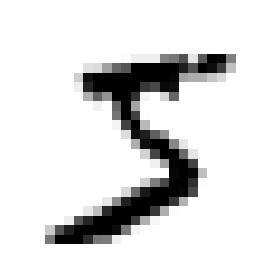

In [14]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

save_fig("some_digit_plot")
plt.show()

Esto parece un 5 y, de hecho, eso es lo que nos dice la etiqueta:

In [17]:
y[0]

'5'

Tenga en cuenta que la etiqueta es una cadena. Preferimos números, así que los convertirémos a enteros: 

In [19]:
y = y.astype(np.uint8)

Aquí se muestran algunas imágenes del conjunto de datos MNIST para darle una idea de la complejidad de la tarea de clasificación.

In [20]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [21]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Saving figure more_digits_plot


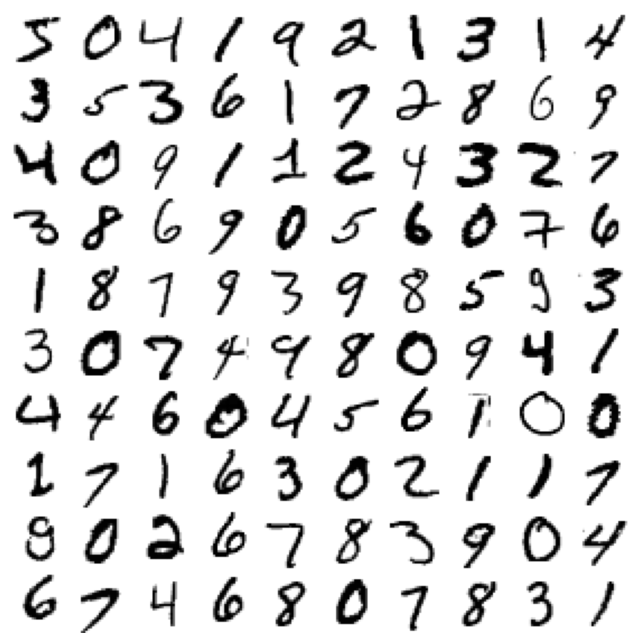

In [22]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

In [24]:
y[0]

5

Siempre debemos de crear un conjunto de prueba y dejarlo a un lado antes de inspeccionar los datos de cerca. El conjunto de datos MNIST ya está dividido en un conjunto de entrenamiento (las primeras 60,000 imágenes) y un conjunto de prueba (las últimas 10,000 imágenes):

In [25]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

El conjunto de entrenamiento ya está barajado para nosotros, lo cual es bueno, ya que garantiza que todos los pliegues de validación cruzada serán similares (no desea que a un pliegue le falten algunos dígitos). Además, algunos algoritmos de aprendizaje son sensibles al orden de las instancias de capacitación y funcionan mal si obtienen muchas instancias similares seguidas. Mezclar el conjunto de datos garantiza que esto no suceda.

# Training a Binary Classifier

Simplifiquemos el problema por ahora e intentemos identificar solo un dígito, por ejemplo, el número 5. Este "detector de 5" será un ejemplo de un clasificador binario, capaz de distinguir entre solo dos clases, 5 y no 5. Creemos los vectores de destino para esta tarea de clasificación:


In [27]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

* Nota: algunos hiperparámetros tendrán un valor predeterminado diferente en versiones futuras de Scikit-Learn, como max_iter y tol. Para estar preparados para el futuro, establecemos explícitamente estos hiperparámetros en sus valores predeterminados futuros.

Bien, ahora elija un clasificador y entrenelo. Un buen lugar para comenzar es con un clasificador de descenso de gradiente estocástico (SGD), utilizando la clase SGDClassifier de Scikit-Learn. Este clasificador tiene la ventaja de poder manejar conjuntos de datos muy grandes de manera eficiente. Esto se debe en parte a que SGD se ocupa de las instancias de formación de forma independiente, una a la vez (lo que también hace que SGD sea adecuado para el aprendizaje en línea), como veremos más adelante. Vamos a crear un SGDClassifier y entrenarlo en todo el conjunto de entrenamiento: